In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import os,re
import numpy as np
import pandas as pd
import math
import sys

sys.stdout.flush()

# Курс "Рекомендательные системы" -- домашнее задание 1

## Автор материала: доцент ФКН НИУ ВШЭ Дмитрий Игнатов
Можно использовать материал в любых целях, кроме коммерческих. Примеры составлены по мотивам главы 2 книги Т.Сегаран "Программируем коллективный разум" http://www.symbol.ru/alphabet/613828.html

### Срок выполнения: 19 июня 2016 (включительно)




## Словарь с предпочтениями пользователи-фильмы

In [2]:
# Словарь кинокритиков и выставленных ими оценок для небольшого набора
# данных о фильмах
critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5, 
 'The Night Listener': 3.0},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5, 
 'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0, 
 'You, Me and Dupree': 3.5}, 
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5, 'The Night Listener': 4.0},
'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
 'The Night Listener': 4.5, 'Superman Returns': 4.0, 
 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 
 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0}, 
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}

In [3]:
critics['Toby']

{'Snakes on a Plane': 4.5, 'Superman Returns': 4.0, 'You, Me and Dupree': 1.0}

In [4]:
critics['Lisa Rose']['Lady in the Water']


2.5

In [5]:
#вычисление расстояния Евклида
from math import sqrt
sqrt(pow(5-4,2)+pow(4-1,2))


3.1622776601683795

In [6]:
#вычисление сходства
1/(1+sqrt(pow(5-4,2)+pow(4-1,2)))


0.2402530733520421

In [7]:
from math import sqrt
# Возвращает сходство person1 и person2 на основе расстояния
def sim_distance(prefs,person1,person2):
# Получить список предметов, оцененных обоими
    si={}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1
# Если нет ни одной общей оценки, вернуть 0
    if len(si)==0: return 0
# Сложить квадраты разностей
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2)
    for item in prefs[person1] if item in prefs[person2]])
    return 1/(1+sum_of_squares)


In [8]:
sim_distance(critics, 'Lisa Rose','Gene Seymour')

0.14814814814814814

In [9]:
# Возвращает коэффициент корреляции Пирсона между p1 и p2
def sim_pearson(prefs,p1,p2):
# Получить список предметов, оцененных обоими
    si={}
    for item in prefs[p1]: 
        if item in prefs[p2]: si[item]=1

    # Если нет ни одной общей оценки, вернуть 0
    if len(si)==0: return 0

    # Количество соместно оцененных фильм
    n=len(si)
  
    # Вычислить сумму всех предпочтений
    sum1=sum([prefs[p1][it] for it in si])
    sum2=sum([prefs[p2][it] for it in si])
  
    # Вычислить сумму квадратов
    sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq=sum([pow(prefs[p2][it],2) for it in si])	
  
    # Вычислить сумму произведений
    pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])
  
    # Вычислить коэффициент Пирсона
    num=pSum-(sum1*sum2/n)
    den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den==0: return 0

    r=num/den

    return r

In [10]:
sim_pearson(critics,'Lisa Rose','Gene Seymour')


0.39605901719066977

## Ранжирование критиков

In [11]:
# Возвращает список наилучших соответствий для человека из словаря prefs.
# Количество результатов в списке и функция подобия – необязательные
# параметры.
def topMatches(prefs,person,n=5,similarity=sim_pearson):
    scores=[(similarity(prefs,person,other),other)
    for other in prefs if other!=person]
    # Отсортировать список по убыванию оценок
    scores.sort( )
    scores.reverse( )
    return scores[0:n]


In [12]:
topMatches(critics,'Toby',n=3)

[(0.9912407071619299, 'Lisa Rose'),
 (0.9244734516419049, 'Mick LaSalle'),
 (0.8934051474415647, 'Claudia Puig')]

## Рекомендация фильмов (User-based подход)

In [13]:
# Получить рекомендации для заданного человека, пользуясь взвешенным средним
# оценок, данных всеми остальными пользователями
def getRecommendations(prefs,person,similarity=sim_pearson):
    
    totals={}
    simSums={}
    for other in prefs:
    # сравнивать меня с собой же не нужно
        if other==person: continue
        sim=similarity(prefs,person,other)
    # игнорировать нулевые и отрицательные оценки
        if sim<=0: continue
        for item in prefs[other]:
    # оценивать только фильмы, которые я еще не смотрел
            if item not in prefs[person] or prefs[person][item]==0:
    # Коэффициент подобия * Оценка
                totals.setdefault(item,0)
                totals[item]+=prefs[other][item]*sim
        # Сумма коэффициентов подобия
                simSums.setdefault(item,0)
                simSums[item]+=sim
    # Создать нормированный список
    rankings=[(total/simSums[item],item) for item,total in totals.items( )]
    # Вернуть отсортированный список
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [14]:
getRecommendations(critics,'Toby')

[(3.3477895267131013, 'The Night Listener'),
 (2.8325499182641614, 'Lady in the Water'),
 (2.5309807037655645, 'Just My Luck')]

In [15]:
getRecommendations(critics,'Toby', sim_distance)

[(3.5002478401415877, 'The Night Listener'),
 (2.7561242939959363, 'Lady in the Water'),
 (2.461988486074374, 'Just My Luck')]

## Сходство предметов

Как заменить

{'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5}}

на

{'Lady in the Water':{'Lisa Rose':2.5,'Gene Seymour':3.0},
'Snakes on a Plane':{'Lisa Rose':3.5,'Gene Seymour':3.5}}?


In [16]:
def transformPrefs(prefs):
    result={}
    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item,{})
    # Обменять местами человека и предмет
            result[item][person]=prefs[person][item]
    return result

In [17]:
movies=transformPrefs(critics)


In [18]:
movies

{'Just My Luck': {'Claudia Puig': 3.0,
  'Gene Seymour': 1.5,
  'Lisa Rose': 3.0,
  'Mick LaSalle': 2.0},
 'Lady in the Water': {'Gene Seymour': 3.0,
  'Jack Matthews': 3.0,
  'Lisa Rose': 2.5,
  'Michael Phillips': 2.5,
  'Mick LaSalle': 3.0},
 'Snakes on a Plane': {'Claudia Puig': 3.5,
  'Gene Seymour': 3.5,
  'Jack Matthews': 4.0,
  'Lisa Rose': 3.5,
  'Michael Phillips': 3.0,
  'Mick LaSalle': 4.0,
  'Toby': 4.5},
 'Superman Returns': {'Claudia Puig': 4.0,
  'Gene Seymour': 5.0,
  'Jack Matthews': 5.0,
  'Lisa Rose': 3.5,
  'Michael Phillips': 3.5,
  'Mick LaSalle': 3.0,
  'Toby': 4.0},
 'The Night Listener': {'Claudia Puig': 4.5,
  'Gene Seymour': 3.0,
  'Jack Matthews': 3.0,
  'Lisa Rose': 3.0,
  'Michael Phillips': 4.0,
  'Mick LaSalle': 3.0},
 'You, Me and Dupree': {'Claudia Puig': 2.5,
  'Gene Seymour': 3.5,
  'Jack Matthews': 3.5,
  'Lisa Rose': 2.5,
  'Mick LaSalle': 2.0,
  'Toby': 1.0}}

In [19]:
topMatches(movies,'Superman Returns')

[(0.6579516949597695, 'You, Me and Dupree'),
 (0.4879500364742689, 'Lady in the Water'),
 (0.11180339887498941, 'Snakes on a Plane'),
 (-0.1798471947990544, 'The Night Listener'),
 (-0.42289003161103106, 'Just My Luck')]

In [20]:
getRecommendations(movies,'Just My Luck')

[(4.0, 'Michael Phillips'), (3.0, 'Jack Matthews')]

## Коллаборативная фильтрация по сходству объектов (Item-based collaborative filtering)

In [21]:
def calculateSimilarItems(prefs,n=10, verbose = True):
    # Создать словарь, содержащий для каждого образца те образцы, которые
    # больше всего похожи на него.
    result={}
    # Обратить матрицу предпочтений, чтобы строки соответствовали образцам
    itemPrefs=transformPrefs(prefs)
    c=0
    for item in itemPrefs:
    # Обновление состояния для больших наборов данных
        c+=1
        if verbose:
            if c%100==0: print "%d / %d" % (c,len(itemPrefs))
    # Найти образцы, максимально похожие на данный
        scores=topMatches(itemPrefs,item,n=n,similarity=sim_distance)
        result[item]=scores
    return result

In [22]:
itemsim=calculateSimilarItems(critics)
itemsim

{'Just My Luck': [(0.2222222222222222, 'Lady in the Water'),
  (0.18181818181818182, 'You, Me and Dupree'),
  (0.15384615384615385, 'The Night Listener'),
  (0.10526315789473684, 'Snakes on a Plane'),
  (0.06451612903225806, 'Superman Returns')],
 'Lady in the Water': [(0.4, 'You, Me and Dupree'),
  (0.2857142857142857, 'The Night Listener'),
  (0.2222222222222222, 'Snakes on a Plane'),
  (0.2222222222222222, 'Just My Luck'),
  (0.09090909090909091, 'Superman Returns')],
 'Snakes on a Plane': [(0.2222222222222222, 'Lady in the Water'),
  (0.18181818181818182, 'The Night Listener'),
  (0.16666666666666666, 'Superman Returns'),
  (0.10526315789473684, 'Just My Luck'),
  (0.05128205128205128, 'You, Me and Dupree')],
 'Superman Returns': [(0.16666666666666666, 'Snakes on a Plane'),
  (0.10256410256410256, 'The Night Listener'),
  (0.09090909090909091, 'Lady in the Water'),
  (0.06451612903225806, 'Just My Luck'),
  (0.05333333333333334, 'You, Me and Dupree')],
 'The Night Listener': [(0.28

In [23]:
def getRecommendedItems(prefs,itemMatch,user):
    userRatings=prefs[user]
    scores={}
    totalSim={}

    # Цикл по образцам, оцененным данным пользователем
    for (item,rating) in userRatings.items():
        
    # Цикл по образцам, похожим на данный
        for (similarity,item2) in itemMatch[item]:
    # Пропускаем, если пользователь уже оценивал данный образец
            if item2 in userRatings: continue
        # Взвешенная суммы оценок, умноженных на коэффициент подобия
            scores.setdefault(item2,0)
            scores[item2]+=similarity*rating
        # Сумма всех коэффициентов подобия
            totalSim.setdefault(item2,0)
            totalSim[item2]+=similarity
            if totalSim[item2]==0: totalSim[item2]=0.0000001 # чтобы избежать деления на ноль
    # Делим каждую итоговую оценку на взвешенную сумму, чтобы вычислить
    # среднее
    rankings=[(score/totalSim[item],item) for item,score in scores.items( ) ]

    # Возвращает список rankings, отсортированный по убыванию
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [24]:
getRecommendedItems(critics,itemsim,'Toby')


[(3.182634730538922, 'The Night Listener'),
 (2.5983318700614575, 'Just My Luck'),
 (2.4730878186968837, 'Lady in the Water')]

## Рекомендация на данных MovieLens

Источник: http://grouplens.org/datasets/movielens/

In [25]:
def loadMovieLens(path='data/movielens'):
# Получить названия фильмов
    movies={}
    for line in open(path+'/u.item'):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
# Загрузить данные
    prefs={}
    for line in open(path+'/u.data'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs

In [26]:
prefs=loadMovieLens( )
prefs['87']

{'2001: A Space Odyssey (1968)': 5.0,
 'Ace Ventura: Pet Detective (1994)': 4.0,
 'Addams Family Values (1993)': 2.0,
 'Addicted to Love (1997)': 4.0,
 'Adventures of Priscilla, Queen of the Desert, The (1994)': 3.0,
 'Adventures of Robin Hood, The (1938)': 5.0,
 'Air Force One (1997)': 3.0,
 'Air Up There, The (1994)': 3.0,
 'Alien (1979)': 4.0,
 'American President, The (1995)': 5.0,
 'Annie Hall (1977)': 4.0,
 'Apocalypse Now (1979)': 4.0,
 'Babe (1995)': 5.0,
 'Baby-Sitters Club, The (1995)': 2.0,
 'Back to the Future (1985)': 5.0,
 'Bad Boys (1995)': 4.0,
 'Bananas (1971)': 5.0,
 'Barcelona (1994)': 3.0,
 'Batman & Robin (1997)': 4.0,
 'Batman (1989)': 3.0,
 'Batman Returns (1992)': 3.0,
 'Big Green, The (1995)': 3.0,
 'Big Squeeze, The (1996)': 2.0,
 'Birdcage, The (1996)': 4.0,
 'Blade Runner (1982)': 4.0,
 'Blues Brothers, The (1980)': 5.0,
 'Boomerang (1992)': 3.0,
 'Boot, Das (1981)': 4.0,
 'Brady Bunch Movie, The (1995)': 2.0,
 'Braveheart (1995)': 4.0,
 'Bridge on the River

In [27]:
getRecommendations(prefs,'87')[0:30]

[(5.0, 'They Made Me a Criminal (1939)'),
 (5.0, 'Star Kid (1997)'),
 (5.0, 'Santa with Muscles (1996)'),
 (5.0, 'Saint of Fort Washington, The (1993)'),
 (5.0, 'Marlene Dietrich: Shadow and Light (1996) '),
 (5.0, 'Great Day in Harlem, A (1994)'),
 (5.0, 'Entertaining Angels: The Dorothy Day Story (1996)'),
 (5.0, 'Boys, Les (1997)'),
 (4.89884443128923, 'Legal Deceit (1997)'),
 (4.815019082242709, 'Letter From Death Row, A (1998)'),
 (4.7321082983941425, 'Hearts and Minds (1996)'),
 (4.696244466490867, 'Pather Panchali (1955)'),
 (4.652397061026758, 'Lamerica (1994)'),
 (4.538723693474813, 'Leading Man, The (1996)'),
 (4.535081339106103, 'Mrs. Dalloway (1997)'),
 (4.532337612572981, 'Innocents, The (1961)'),
 (4.527998574747079, 'Casablanca (1942)'),
 (4.510270149719864, 'Everest (1998)'),
 (4.493967755428439, 'Dangerous Beauty (1998)'),
 (4.485151301801342, 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (4.463287461290222, 'Wrong Trousers, The (1993)'),
 (4.450979436941

In [28]:
itemsim=calculateSimilarItems(prefs,n=50)

100 / 1664
200 / 1664
300 / 1664
400 / 1664
500 / 1664
600 / 1664
700 / 1664
800 / 1664
900 / 1664
1000 / 1664
1100 / 1664
1200 / 1664
1300 / 1664
1400 / 1664
1500 / 1664
1600 / 1664


In [29]:
getRecommendedItems(prefs,itemsim,'87')[0:30]

[(5.0, "What's Eating Gilbert Grape (1993)"),
 (5.0, 'Vertigo (1958)'),
 (5.0, 'Usual Suspects, The (1995)'),
 (5.0, 'Toy Story (1995)'),
 (5.0, 'Titanic (1997)'),
 (5.0, 'Sword in the Stone, The (1963)'),
 (5.0, 'Stand by Me (1986)'),
 (5.0, 'Sling Blade (1996)'),
 (5.0, 'Silence of the Lambs, The (1991)'),
 (5.0, 'Shining, The (1980)'),
 (5.0, 'Shine (1996)'),
 (5.0, 'Sense and Sensibility (1995)'),
 (5.0, 'Scream (1996)'),
 (5.0, 'Rumble in the Bronx (1995)'),
 (5.0, 'Rock, The (1996)'),
 (5.0, 'Robin Hood: Prince of Thieves (1991)'),
 (5.0, 'Reservoir Dogs (1992)'),
 (5.0, 'Police Story 4: Project S (Chao ji ji hua) (1993)'),
 (5.0, 'House of the Spirits, The (1993)'),
 (5.0, 'Fresh (1994)'),
 (5.0, 'Denise Calls Up (1995)'),
 (5.0, 'Day the Sun Turned Cold, The (Tianguo niezi) (1994)'),
 (5.0, 'Before the Rain (Pred dozhdot) (1994)'),
 (5.0, 'Assignment, The (1997)'),
 (5.0, '1-900 (1994)'),
 (4.875, "Ed's Next Move (1996)"),
 (4.833333333333333, 'Anna (1996)'),
 (4.8, 'Dark City 

# Задание 1. Сравнение методов коллаборативной фильтрации по сходству пользователей и по сходству объектов


1. Требуется реализовать вычисление ошибки [MAE](http://www.recsyswiki.com/wiki/Mean_absolute_error) и [RMSE](http://www.recsyswiki.com/wiki/Root_mean_square_error-mean-square_deviation) на тестовых данных [Movie Lens](http://grouplens.org/datasets/movielens/).  
В качестве данных обучения можно использовать файлы с расширением base, а тестирование качества провести на файле test: пары файлов u1.base и u1.test, ..., u5.base и u5.test. Каждая пара -- это разбиение 80%/20%  данных для всех пользователей $u$ на обучащие и тестовые данные.
2. Для каждого метода (user-based и item-based) постройте графики зависимости [MAE](http://www.recsyswiki.com/wiki/Mean_absolute_error) и [RMSE](http://www.recsyswiki.com/wiki/Root_mean_square_error-mean-square_deviation) от числа соседей (диапазон от 1 до 100 с разумным шагом).
3. Если качество предсказаний слишком низкое (MAE>2,0), то попробуйте формулы 2.6 и 2.7 из обзора http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf.
Можно использовать альтернативные формулы для исходной модели $r_{u,i} = k\sum\limits_{u^\prime \in U}\operatorname{sim}(u,u^\prime)r_{u^\prime, i} \mbox{ (случай user-based модели):}$
$$r_{u,i} = \frac{1}{N}\sum\limits_{u^\prime \in U}r_{u^\prime, i}$$
$$r_{u,i} = \bar{r_u} +  k\sum\limits_{u^\prime \in U} sim(u,u^\prime)(r_{u^\prime, i}-\bar{r_{u^\prime}} ) \mbox{, где } k =1/\sum_{u^\prime \in U}|\operatorname{sim}(u,u^\prime)|.$$
4. Сравните подходы на основе полученных результатов по аналогии с пунктами 1 и 2. 
5. Как изменяется величина MAE (RMSE) от числа выдаваемых рекомендаций (top-n): $n \in \{1,3,5,10,15,20,30,40,50,100\}$? 
6. Как Вы считаете, какие фильмы чаще рекомендуются -- популярные с высокими оценками или редкие (те, которые редко оцениваются) с высокими оценками?
7. Что делать, если соседей (то есть похожих на целевого пользователя или конкретный товар) мало? Нужно/можно ли как-то учитывать достоверность таких рекомендаций? 
8. *Необязательное подзадание.* Насколько различны списки из top-n рекомендаций. Попробуйте улучшить результаты подбором $\beta$ для минимизации MAE (RMSE) в гибридных рекомендациях в зависимости от числа соседей:
$$\beta\cdot r^{user-based}_{ui} + (1-\beta)\cdot r^{item-based}_{ui}, \mbox{ где } 0 \leq \beta \leq 1.$$ 



In [30]:
##
## Load test and train sets for MovieLens_db
##

def loadMovieLens_train_test(path='data/movielens', k = 1):
    
# Получить названия фильмов
    movies={}
    for line in open(path+'/u.item'):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
# Загрузить данные
    prefs_train={}
    prefs_test={}
    
    print (path+'/u' + str(k) + '.base')
    for line in open(path+'/u' + str(k) + '.base'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs_train.setdefault(user,{})
        prefs_train[user][movies[movieid]]=float(rating)
        
    print (path+'/u' + str(k) + '.test')
    for line in open(path+'/u' + str(k) + '.test'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs_test.setdefault(user,{})
        prefs_test[user][movies[movieid]]=float(rating)                
                
    return prefs_train, prefs_test

In [31]:
prefs_train, prefs_test = loadMovieLens_train_test(k=3)

data/movielens/u3.base
data/movielens/u3.test


In [32]:
print (len(prefs_train.keys()))
print (len(prefs_test.keys()))

943
869


In [33]:
##
##   Get recommendations for test users - only recommendations on films that they've ranked 
##

def getRecommended_Item_based(prefs_test, prefs_train, itemMatch,user):
    
    userRatings_test  = prefs_test[user]
    userRatings_train = prefs_train[user]
    scores = {}
    totalSim={}

    # Цикл по образцам, оцененным данным пользователем
    for (item,rating) in userRatings_train.items():
        
        if item not in itemMatch: continue
            
        # Цикл по образцам, похожим на данный
        for (similarity,item2) in itemMatch[item]:
            
        # Пропускаем, если пользователь не оценивал данный образец в тестовой выборке
        
            if item2 not in userRatings_test: continue
        # Взвешенная суммы оценок, умноженных на коэффициент подобия
            scores.setdefault(item2,0)
            scores[item2]+=similarity*rating
        # Сумма всех коэффициентов подобия
            totalSim.setdefault(item2,0)
            totalSim[item2]+=similarity
            if totalSim[item2]==0: totalSim[item2]=0.0000001 # чтобы избежать деления на ноль
    # Делим каждую итоговую оценку на взвешенную сумму, чтобы вычислить
    # среднее
    rankings=[(score/totalSim[item],item) for item,score in scores.items( ) ]

    # Возвращает список rankings, отсортированный по убыванию
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [34]:
###
###  User based recommendations
###

def getRecommended_User_based (prefs_test, prefs_train, item_sim, user):
    
    prefs_top_matches = item_sim[user]
    totals={}
    simSums={}
    
    for (sim, other) in prefs_top_matches:
    # сравнивать меня с собой же не нужно
        if other == user: continue

    # игнорировать нулевые и отрицательные оценки
        if sim<=0: continue
        for item in prefs_train[other]:
    # оценивать только фильмы, которые есть в тесте
            if item in prefs_test[user]:
    # Коэффициент подобия * Оценка
                totals.setdefault(item,0)
                totals[item] += prefs_train[other][item]*sim
        # Сумма коэффициентов подобия
                simSums.setdefault(item,0)
                simSums[item] += sim
                
    # Создать нормированный список
    rankings=[(total/simSums[item],item) for item,total in totals.items( )]
    # Вернуть отсортированный список
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [35]:
## error score function:
## pow_val = 1 - MAE
## pow_val = 2 - RMSE

def Error_score (user_recommendations, user_true_scores, pow_val = 1):
    
    mae_value    = 0
    counter_val  = 0
    for film_score_iter in user_recommendations:
        film_name = film_score_iter[1]
        film_score = film_score_iter[0]
        
        if film_name in user_true_scores:
            mae_value += abs(film_score - user_true_scores[film_name]) **pow_val
            counter_val += 1
        ##print (film_name, film_score_iter[0], user_true_scores[film_name])
    
    return [counter_val, mae_value]

In [36]:
## Calculate sum of error score
##

def get_error_score_for_test_data (prefs_test, prefs_train, itemsim = {}, 
                                   recom_type = "item-based", n_neighb = 5,  pow_val = 1, n_reco = 0):
    err_score_total = 0
    counter_total = 0

    for user_id in prefs_test.keys():
        ##print (user_id)
        user_recommendations =  []
        if recom_type == "item-based":
            user_recommendations = getRecommended_Item_based (prefs_test, prefs_train, itemsim, user_id)
            
        elif recom_type == "user-based":
            user_recommendations = getRecommended_User_based (prefs_test, prefs_train, itemsim, user_id)
        
        elif recom_type == "user-based2":
            ## with user mean substraction
            user_recommendations = getRecommended_User_based_v2 (prefs_test, prefs_train, itemsim, user_id)

        elif recom_type == "user-based3":
            ## with user mean substraction
            user_recommendations = getRecommended_User_based_v3 (prefs_test, prefs_train, itemsim, user_id)
            
        else:
            print ('"recom_type" not found')
            break
        
        
        if n_reco>0:
            user_recommendations = user_recommendations[0:n_reco] 
        
        ## print (user_recommendations[0:10])
        counter_user, score_user = Error_score (user_recommendations, prefs_test[user_id], pow_val = pow_val)
        err_score_total += score_user
        counter_total += counter_user
        ## print (user_recommendations)
        
        ## print (user_id)
        ## print (score_user)
    
    if (counter_total == 0): counter_total = 0.0001
    ## print (counter_total)    
    
    
    err_score_total = err_score_total/counter_total
    if pow_val == 2:
        err_score_total = math.sqrt(err_score_total)
    
    return err_score_total

In [37]:
##
##  Get item-based recommendations errors
##

n_neighb_val = 1
itemsim=calculateSimilarItems(prefs_train, n = n_neighb_val, verbose = True)
mae_error_val = get_error_score_for_test_data (prefs_test, prefs_train,  itemsim = itemsim, n_neighb = n_neighb_val, recom_type = "item-based", pow_val = 1)
rmse_error_val = get_error_score_for_test_data (prefs_test, prefs_train, itemsim = itemsim, n_neighb = n_neighb_val, recom_type = "item-based", pow_val = 2)

print (mae_error_val, rmse_error_val)

100 / 1634
200 / 1634
300 / 1634
400 / 1634
500 / 1634
600 / 1634
700 / 1634
800 / 1634
900 / 1634
1000 / 1634
1100 / 1634
1200 / 1634
1300 / 1634
1400 / 1634
1500 / 1634
1600 / 1634
(1.1834073831552823, 1.5779550501084765)


In [38]:
## create iteration list for number of neigbours
##

np_arr = np.arange(5,101,5)
np_arr = np.concatenate([np.array([1]),np_arr])
print (np_arr)


[  1   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


In [39]:
##
##  Get item-based recommendations errors
##

mae_array = []
rmse_array = []

for neighb_val in np_arr:
    print ("Number of neighbours: ", neighb_val)
    itemsim=calculateSimilarItems(prefs_train,n=neighb_val, verbose = False)
    mae_error_val = get_error_score_for_test_data (prefs_test, prefs_train, itemsim = itemsim, pow_val = 1)
    rmse_error_val = get_error_score_for_test_data (prefs_test, prefs_train, itemsim = itemsim, pow_val = 2)
    print (mae_error_val, rmse_error_val)
    mae_array +=[mae_error_val]
    rmse_array +=[rmse_error_val]
    

('Number of neighbours: ', 1)
(1.1834073831552823, 1.5779550501084765)
('Number of neighbours: ', 5)
(1.150383927489475, 1.5091736340707136)
('Number of neighbours: ', 10)
(1.1290321094204092, 1.4795130409456059)
('Number of neighbours: ', 15)
(1.0996235866885324, 1.4353830126602236)
('Number of neighbours: ', 20)
(1.075851074683617, 1.414227021256659)
('Number of neighbours: ', 25)
(1.078064309392916, 1.4162216447690368)
('Number of neighbours: ', 30)
(1.063875318932803, 1.401499231772736)
('Number of neighbours: ', 35)
(1.0495215504897015, 1.3814185258269174)
('Number of neighbours: ', 40)
(1.0531158931630005, 1.3896663977421313)
('Number of neighbours: ', 45)
(1.0547651754137664, 1.3887041187301925)
('Number of neighbours: ', 50)
(1.04341401576094, 1.3777025528327773)
('Number of neighbours: ', 55)
(1.0425486340705583, 1.3735384844340535)
('Number of neighbours: ', 60)
(1.0422008752075747, 1.3711265465548692)
('Number of neighbours: ', 65)
(1.040399074448417, 1.366326244119988)
('Nu

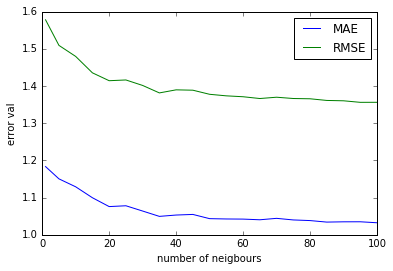

In [40]:
##
##  Graph item based recommendations errors
##

plt.plot(np_arr, mae_array, label='MAE')
plt.plot(np_arr, rmse_array, label = 'RMSE')

plt.legend()
plt.ylabel('error val')
plt.xlabel('number of neigbours')

plt.show()

In [41]:
## Item based filtering have minimum on 30 neighbours

np.column_stack ([np_arr,mae_array])[0:10]

array([[  1.        ,   1.18340738],
       [  5.        ,   1.15038393],
       [ 10.        ,   1.12903211],
       [ 15.        ,   1.09962359],
       [ 20.        ,   1.07585107],
       [ 25.        ,   1.07806431],
       [ 30.        ,   1.06387532],
       [ 35.        ,   1.04952155],
       [ 40.        ,   1.05311589],
       [ 45.        ,   1.05476518]])

In [42]:
def calculateSimilarUsers(prefs_train, prefs_test, n = 40, similarity=sim_pearson, verbose = True):
    # Создать словарь, содержащий для каждого образца те образцы, которые
    # больше всего похожи на него.
    result={}
    c=0

    for user in prefs_test.keys():
        c+=1
        if verbose:
            if c%100==0: print "%d / %d" % (c,len(prefs_test.keys()))
                
        matches = topMatches (prefs_train, user, n=n, similarity=sim_pearson)
        result.setdefault(user,[])
        result [user] = matches
    return result



In [43]:
##  User based recommendations
##

mae_array = []
rmse_array = []

for neighb_val in np_arr:
    
    print ("Number of neighbours: ", neighb_val)
    item_sim = calculateSimilarUsers (prefs_train, prefs_test, n = neighb_val, verbose = False)
    mae_error_val  = get_error_score_for_test_data (prefs_test, prefs_train,  itemsim = item_sim, n_neighb = neighb_val, recom_type = "user-based", pow_val = 1)
    rmse_error_val = get_error_score_for_test_data (prefs_test, prefs_train,  itemsim = item_sim, n_neighb = neighb_val, recom_type = "user-based", pow_val = 2)
    print (mae_error_val, rmse_error_val)
    mae_array +=[mae_error_val]
    rmse_array +=[rmse_error_val]
    

('Number of neighbours: ', 1)
(1.1139630390143738, 1.4581780987096427)
('Number of neighbours: ', 5)
(1.070338882937175, 1.3913393200476403)
('Number of neighbours: ', 10)
(1.0351232453057773, 1.3460348551437828)
('Number of neighbours: ', 15)
(1.0212361245943915, 1.3308384065857712)
('Number of neighbours: ', 20)
(0.9941357796864864, 1.296996449262244)
('Number of neighbours: ', 25)
(0.9829414081067129, 1.2824042448560082)
('Number of neighbours: ', 30)
(0.9680824506983491, 1.2634397401365238)
('Number of neighbours: ', 35)
(0.9611271342629553, 1.2532468573855247)
('Number of neighbours: ', 40)
(0.9467473146031321, 1.23818461568183)
('Number of neighbours: ', 45)
(0.9355611337104225, 1.2210466508729751)
('Number of neighbours: ', 50)
(0.9300202011488066, 1.2095076532849376)
('Number of neighbours: ', 55)
(0.917953330721559, 1.1924860435545355)
('Number of neighbours: ', 60)
(0.9110005681475773, 1.1831046458906906)
('Number of neighbours: ', 65)
(0.9054906104051773, 1.174492984862275)


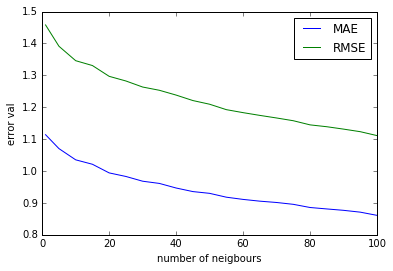

In [44]:
##
##  Graph user based recommendations errors
##

plt.plot(np_arr, mae_array, label='MAE')
plt.plot(np_arr, rmse_array, label = 'RMSE')

plt.legend()
plt.ylabel('error val')
plt.xlabel('number of neigbours')

plt.show()

In [45]:
## Минимум продолжает уменьшаться при увеличении количества пользователей.

np.column_stack ([np_arr,mae_array])[0:10]

array([[  1.        ,   1.11396304],
       [  5.        ,   1.07033888],
       [ 10.        ,   1.03512325],
       [ 15.        ,   1.02123612],
       [ 20.        ,   0.99413578],
       [ 25.        ,   0.98294141],
       [ 30.        ,   0.96808245],
       [ 35.        ,   0.96112713],
       [ 40.        ,   0.94674731],
       [ 45.        ,   0.93556113]])

3. Если качество предсказаний слишком низкое (MAE>2,0), то попробуйте формулы 2.6 и 2.7 из обзора http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf.
Можно использовать альтернативные формулы для исходной модели $r_{u,i} = k\sum\limits_{u^\prime \in U}\operatorname{sim}(u,u^\prime)r_{u^\prime, i} \mbox{ (случай user-based модели):}$
$$r_{u,i} = \frac{1}{N}\sum\limits_{u^\prime \in U}r_{u^\prime, i}$$
$$r_{u,i} = \bar{r_u} +  k\sum\limits_{u^\prime \in U} sim(u,u^\prime)(r_{u^\prime, i}-\bar{r_{u^\prime}} ) \mbox{, где } k =1/\sum_{u^\prime \in U}|\operatorname{sim}(u,u^\prime)|.$$

In [46]:
###
###  User based recommendations
###

## with mean substraction

def getRecommended_User_based_v2 (prefs_test, prefs_train, item_sim, user):
    
    prefs_top_matches = item_sim[user]
    totals={}
    simSums={}
    
    mean_user = sum(prefs_train[user][item] for item in prefs_train[user])/len(prefs_train[user])
    
    
    for (sim, other) in prefs_top_matches:
    # сравнивать меня с собой же не нужно
        if other == user: continue
        mean_other = sum(prefs_train[other][item] for item in prefs_train[other])/len(prefs_train[other])
        
    # игнорировать нулевые и отрицательные оценки
        if sim<=0: continue
        for item in prefs_train[other]:
    # оценивать только фильмы, которые есть в тесте
            if item in prefs_test[user]:
    # Коэффициент подобия * Оценка
                totals.setdefault(item,0)
                totals[item] += (prefs_train[other][item] - mean_other) *sim
        # Сумма коэффициентов подобия
                simSums.setdefault(item,0)
                simSums[item] += sim
                

                
    # Создать нормированный список
    rankings=[(mean_user + total/simSums[item],item) for item,total in totals.items( )]
    # Вернуть отсортированный список
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [47]:
item_sim = calculateSimilarUsers (prefs_train, prefs_test, n = 30, verbose = False)


In [48]:
print ("old recommendation list:")
print (getRecommended_User_based (prefs_test, prefs_train, item_sim, '344'))

print ("\n")
print ("new recommendation list:")
print (getRecommended_User_based_v2 (prefs_test, prefs_train, item_sim, '344'))

old recommendation list:
[(4.513167019494862, 'Secrets & Lies (1996)'), (4.510333259442322, 'Clueless (1995)'), (4.39329978324303, 'Godfather, The (1972)'), (4.30056337382839, 'Tomorrow Never Dies (1997)'), (4.244776452610301, 'Full Monty, The (1997)'), (4.16271173892865, "Ulee's Gold (1997)"), (4.0, 'Mighty Aphrodite (1995)'), (4.0, 'Heat (1995)'), (3.973849333685201, 'Leaving Las Vegas (1995)'), (3.9207896100569415, 'Wings of the Dove, The (1997)'), (3.690711997094568, 'Silence of the Lambs, The (1991)'), (3.0, 'Wrong Trousers, The (1993)'), (3.0, 'First Wives Club, The (1996)'), (3.0, 'Aladdin (1992)')]


new recommendation list:
[(4.629305258575195, 'Godfather, The (1972)'), (4.46342812163157, 'Secrets & Lies (1996)'), (4.416972192942474, "Ulee's Gold (1997)"), (4.413432395363291, 'Clueless (1995)'), (4.391707234977075, 'Full Monty, The (1997)'), (4.388154257552725, 'Tomorrow Never Dies (1997)'), (4.289499171405507, 'Wings of the Dove, The (1997)'), (4.193392477414005, 'Silence of 

In [49]:
##  User based recommendations
##

##  with mean substraction
##

mae_array = []
rmse_array = []

for neighb_val in np_arr:
    
    print ("Number of neighbours: ", neighb_val)
    item_sim = calculateSimilarUsers (prefs_train, prefs_test, n = neighb_val, verbose = False)
    mae_error_val  = get_error_score_for_test_data (prefs_test, prefs_train,  itemsim = item_sim, n_neighb = neighb_val, recom_type = "user-based2", pow_val = 1)
    rmse_error_val = get_error_score_for_test_data (prefs_test, prefs_train,  itemsim = item_sim, n_neighb = neighb_val, recom_type = "user-based2", pow_val = 2)
    print (mae_error_val, rmse_error_val)
    mae_array +=[mae_error_val]
    rmse_array +=[rmse_error_val]

('Number of neighbours: ', 1)
(1.1048103811817984, 1.4128340998041455)
('Number of neighbours: ', 5)
(1.0597483495228304, 1.353555271313155)
('Number of neighbours: ', 10)
(1.0233788223979357, 1.3082965495636922)
('Number of neighbours: ', 15)
(1.005834836938332, 1.288255011466573)
('Number of neighbours: ', 20)
(0.9744212535343494, 1.249603843828416)
('Number of neighbours: ', 25)
(0.9626122539415799, 1.2338437899609844)
('Number of neighbours: ', 30)
(0.948646692216957, 1.2144420810195284)
('Number of neighbours: ', 35)
(0.9414603519897505, 1.206892772289036)
('Number of neighbours: ', 40)
(0.9289377066760013, 1.194592129220388)
('Number of neighbours: ', 45)
(0.9156148192528134, 1.1769691344290412)
('Number of neighbours: ', 50)
(0.9065442806398335, 1.1640551056034218)
('Number of neighbours: ', 55)
(0.8943733776745365, 1.1483281468297768)
('Number of neighbours: ', 60)
(0.886618848060713, 1.1384707171035062)
('Number of neighbours: ', 65)
(0.8792661709951153, 1.1295762506742804)
('

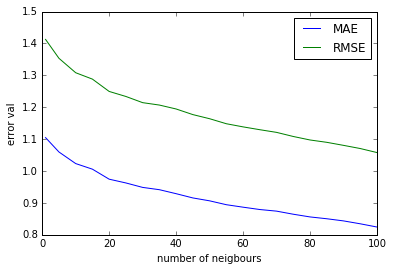

In [50]:
##
##  Graph user based recommendations errors with mean substracted
##

plt.plot(np_arr, mae_array, label='MAE')
plt.plot(np_arr, rmse_array, label = 'RMSE')

plt.legend()
plt.ylabel('error val')
plt.xlabel('number of neigbours')

plt.show()

In [51]:
###
###  User based recommendations
###

##  with mean and std substraction
##

def getRecommended_User_based_v3 (prefs_test, prefs_train, item_sim, user):
    
    prefs_top_matches = item_sim[user]
    totals={}
    simSums={}
    
    mean_user = sum(prefs_train[user][item] for item in prefs_train[user])/len(prefs_train[user])
    std_user  = np.std(list(prefs_train[user][item] for item in prefs_train[user]))
    
    for (sim, other) in prefs_top_matches:
    # сравнивать меня с собой же не нужно
        if other == user: continue
        mean_other = sum(prefs_train[other][item] for item in prefs_train[other])/len(prefs_train[other])
        std_other  = np.std(list(prefs_train[other][item] for item in prefs_train[other]))
                           
    # игнорировать нулевые и отрицательные оценки
        if sim<=0: continue
        for item in prefs_train[other]:
    # оценивать только фильмы, которые есть в тесте
            if item in prefs_test[user]:
    # Коэффициент подобия * Оценка
                totals.setdefault(item,0)
                totals[item] += (prefs_train[other][item] - mean_other) *sim / std_other
        # Сумма коэффициентов подобия
                simSums.setdefault(item,0)
                simSums[item] += sim
                

                
    # Создать нормированный список
    rankings=[(mean_user + std_user * total/simSums[item],item) for item,total in totals.items( )]
    # Вернуть отсортированный список
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [52]:
print ("old recommendation list:")
print (getRecommended_User_based (prefs_test, prefs_train, item_sim, '344'))

print ("\n")
print ("new recommendation list:")
print (getRecommended_User_based_v3 (prefs_test, prefs_train, item_sim, '344'))

old recommendation list:
[(5.0, 'Beautiful Thing (1996)'), (4.552004480775902, 'Local Hero (1983)'), (4.482393162712514, 'Godfather, The (1972)'), (4.354656753935738, 'Secrets & Lies (1996)'), (4.28628478179148, 'Strictly Ballroom (1992)'), (4.192336245439397, 'Philadelphia Story, The (1940)'), (4.138206746680092, 'Full Monty, The (1997)'), (4.13250921706428, 'Remains of the Day, The (1993)'), (4.08168348309007, 'Silence of the Lambs, The (1991)'), (4.009339232524528, 'Lion King, The (1994)'), (4.0, 'Persuasion (1995)'), (3.944860537495577, 'Wings of the Dove, The (1997)'), (3.9318231529209036, 'Leaving Las Vegas (1995)'), (3.868875935471928, "Ulee's Gold (1997)"), (3.844333059148385, 'Mighty Aphrodite (1995)'), (3.8352370234569495, 'Get Shorty (1995)'), (3.5796017574932044, 'Unforgiven (1992)'), (3.5399598892880633, 'Seven (Se7en) (1995)'), (3.5133884217515052, 'His Girl Friday (1940)'), (3.5129924428235286, 'Brothers McMullen, The (1995)'), (3.4720312596111307, 'Tomorrow Never Dies (

In [117]:
##  User based recommendations
##

##  with mean and std substraction
##

mae_array = []
rmse_array = []

for neighb_val in np_arr:
    
    print ("Number of neighbours: ", neighb_val)
    item_sim = calculateSimilarUsers (prefs_train, prefs_test, n = neighb_val, verbose = False)
    mae_error_val  = get_error_score_for_test_data (prefs_test, prefs_train,  itemsim = item_sim, n_neighb = neighb_val, recom_type = "user-based3", pow_val = 1)
    rmse_error_val = get_error_score_for_test_data (prefs_test, prefs_train,  itemsim = item_sim, n_neighb = neighb_val, recom_type = "user-based3", pow_val = 2)
    print (mae_error_val, rmse_error_val)
    mae_array +=[mae_error_val]
    rmse_array +=[rmse_error_val]

('Number of neighbours: ', 1)
(1.0846672949716039, 1.4078007050856596)
('Number of neighbours: ', 5)
(1.0355053629341651, 1.3390703363357486)
('Number of neighbours: ', 10)
(1.0033147636610391, 1.2988316155205542)
('Number of neighbours: ', 15)
(0.98681788603139475, 1.2770799043383154)
('Number of neighbours: ', 20)
(0.95799892220847971, 1.2420786244293998)
('Number of neighbours: ', 25)
(0.94620064724520103, 1.224847276436161)
('Number of neighbours: ', 30)
(0.93570775045240329, 1.208820761785288)
('Number of neighbours: ', 35)
(0.93004070263048577, 1.2015586533076275)
('Number of neighbours: ', 40)
(0.91793844903560351, 1.188851121241454)
('Number of neighbours: ', 45)
(0.90484079584964239, 1.1706895104167974)
('Number of neighbours: ', 50)
(0.89648800013448182, 1.1584720571637082)
('Number of neighbours: ', 55)
(0.88456029893592913, 1.1441464301577418)
('Number of neighbours: ', 60)
(0.87569996179706588, 1.1313628912580385)
('Number of neighbours: ', 65)
(0.87104900130414797, 1.1253

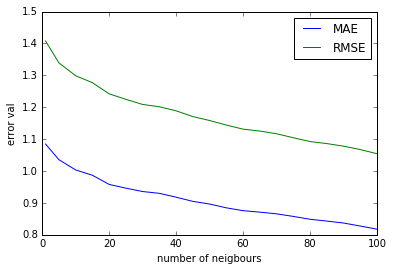

In [118]:
##
##  Graph user based recommendations errors with mean substracted
##

plt.plot(np_arr, mae_array, label='MAE')
plt.plot(np_arr, rmse_array, label = 'RMSE')

plt.legend()
plt.ylabel('error val')
plt.xlabel('number of neigbours')

plt.show()

##### Сравните подходы на основе полученных результатов по аналогии с пунктами 1 и 2:

формулы 2.6 и 2.7 дают лучшие результаты по сравнению с обычными формулами для user_based и item_based. Для 30 соседей видим улучшение с 0.982 (user-based) до 0.946 (user-based + mean + std)


#####  Как изменяется величина MAE (RMSE) от числа выдаваемых рекомендаций (top-n): $n \in \{1,3,5,10,15,20,30,40,50,100\}$? 


In [55]:
n_reco_arr = [1,3,5,10,15,20,30,40,50,100]

In [56]:
mae_array = []
rmse_array = []

neighb_val = 30
for n_reco_val in n_reco_arr:
    
    print ("Number of recommendations: ", n_reco_val)
    item_sim = calculateSimilarUsers (prefs_train, prefs_test, n = neighb_val, verbose = False)
    mae_error_val  = get_error_score_for_test_data (prefs_test, prefs_train,  itemsim = item_sim, n_neighb = neighb_val, 
                                                    recom_type = "user-based3", pow_val = 1, n_reco = n_reco_val)
    rmse_error_val = get_error_score_for_test_data (prefs_test, prefs_train,  itemsim = item_sim, n_neighb = neighb_val, 
                                                    recom_type = "user-based3", pow_val = 2, n_reco = n_reco_val)
    print (mae_error_val, rmse_error_val)
    mae_array +=[mae_error_val]
    rmse_array +=[rmse_error_val]

('Number of recommendations: ', 1)
(0.98305074600815234, 1.2819546166183862)
('Number of recommendations: ', 3)
(0.92936360809444651, 1.216489046376814)
('Number of recommendations: ', 5)
(0.90570277971983126, 1.1794918349310322)
('Number of recommendations: ', 10)
(0.91406273309656161, 1.187176504437101)
('Number of recommendations: ', 15)
(0.91859956260127962, 1.1898045757416373)
('Number of recommendations: ', 20)
(0.92227730836538202, 1.1931044321894848)
('Number of recommendations: ', 30)
(0.92832146176630415, 1.198480869783702)
('Number of recommendations: ', 40)
(0.93234724049385365, 1.203952994392385)
('Number of recommendations: ', 50)
(0.93403106680682679, 1.2056484190525723)
('Number of recommendations: ', 100)
(0.93568972077222134, 1.2088337441802592)


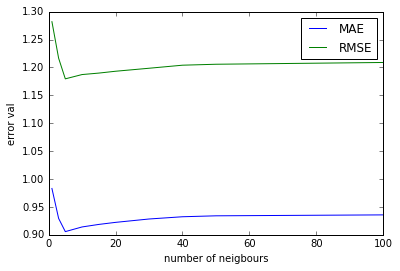

In [57]:
##
##  Graph user based recommendations errors with mean substracted
##

plt.plot(n_reco_arr, mae_array, label='MAE')
plt.plot(n_reco_arr, rmse_array, label = 'RMSE')

plt.legend()
plt.ylabel('error val')
plt.xlabel('number of neigbours')

plt.show()

#####  Как Вы считаете, какие фильмы чаще рекомендуются -- популярные с высокими оценками или редкие (те, которые редко оцениваются) с высокими оценками?

Чаще всего рекомедуют фильмы популярные с высокими оценками. Фильмы, для которых мало оценок не рекомендуют, потому что высока вероятность нерелевантности выдачи из-за недостоверности оценки.


#####  Что делать, если соседей (то есть похожих на целевого пользователя или конкретный товар) мало? Нужно/можно ли как-то учитывать достоверность таких рекомендаций?

Достоверность таких рекомендаций должна ставиться под вопрос. Из-за недостаточности данных оценки нельзя считать релевантными. 

В общем случае можно придумать отдельную модель для всех фильмов, у которых мало оценок и давать им оценку в зависимости от того, что будет показывать эта модель. Например, взять линейную регрессию с кучей фич на основе данных по фильмам (описания, год выпуска, жанра, режиссёра и тп.), плюс фичи на основе статистик по имеющимся оценкам (средние, отклонения и тп.).

Также, как вариант, можно использовать метод, описанный в книге "Баесовские методы для Хакеров" - ранжирование фильмов на основе доверительных интервалов для оценки: http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Chapter4.ipynb



#####   *Необязательное подзадание.* Насколько различны списки из top-n рекомендаций. Попробуйте улучшить результаты подбором $\beta$ для минимизации MAE (RMSE) в гибридных рекомендациях в зависимости от числа соседей:
$$\beta\cdot r^{user-based}_{ui} + (1-\beta)\cdot r^{item-based}_{ui}, \mbox{ где } 0 \leq \beta \leq 1.$$ 


In [108]:

def get_error_score_for_hybrid_model_test_data (prefs_test, prefs_train, itemsim = {}, usersim = {},
                                                pow_val = 1, n_reco = 0, beta = 0):
    err_score_total = 0
    counter_total = 0
    
    if (beta<0 or beta>1):
        return "Error beta value"
    
    for user_id in prefs_test.keys():
        ##print (user_id)
        user_recommendations = []
        
        user_recommendations_item =  []
        user_recommendations_item = getRecommended_Item_based  (prefs_test, prefs_train, itemsim, user_id)

            ## with user mean substraction
        user_recommendations_user =  []
        user_recommendations_user = getRecommended_User_based_v3 (prefs_test, prefs_train, usersim, user_id)
        

        dict_hybrid_reco = {}
        for (score, film_name) in user_recommendations_user:
            dict_hybrid_reco.setdefault(film_name,0)
            dict_hybrid_reco[film_name] = score
        
        ## print (dict_hybrid_reco)
        
        ## Only apply beta adjustment for films ranked by user-user approach
        for (score, film_name) in user_recommendations_item:
            if film_name in dict_hybrid_reco.keys():
                dict_hybrid_reco[film_name] = dict_hybrid_reco[film_name] * beta + score * (1-beta)



        user_recommendations = []
        user_recommendations = [(total,item) for item, total in dict_hybrid_reco.items( )]
        user_recommendations.sort()
        user_recommendations.reverse()
        
        if n_reco>0:
            user_recommendations = user_recommendations[0:n_reco] 
        
        counter_user, score_user = Error_score (user_recommendations, prefs_test[user_id], pow_val = pow_val)
        err_score_total += score_user
        counter_total += counter_user

    
    if (counter_total == 0): counter_total = 0.0001    
    
    err_score_total = err_score_total/counter_total
    if pow_val == 2:
        err_score_total = math.sqrt(err_score_total)
    
    return err_score_total

In [111]:
## user based reco:
neighb_val = 30 
user_sim = calculateSimilarUsers (prefs_train, prefs_test, n = neighb_val, verbose = True)
item_sim  = calculateSimilarItems (prefs_train, n=neighb_val, verbose = True)

get_error_score_for_hybrid_model_test_data (prefs_test, prefs_train, item_sim, user_sim, pow_val = 1, beta = 0.5 )

0.93010953759596848

In [114]:
mae_array = []
rmse_array = []
beta_array = np.arange (0,1.1,0.1)

for beta_iter_val in beta_array:
    print ("beta value: ", beta_iter_val)
    mae_error_val = get_error_score_for_hybrid_model_test_data (prefs_test, prefs_train, item_sim, user_sim,  pow_val = 1, beta = beta_iter_val)
    rmse_error_val = get_error_score_for_hybrid_model_test_data (prefs_test, prefs_train, item_sim, user_sim, pow_val = 2, beta = beta_iter_val)
    
    print (mae_error_val, rmse_error_val)
    mae_array +=[mae_error_val]
    rmse_array +=[rmse_error_val]

('beta value: ', 0.0)
(0.94190562897757379, 1.2209907347453302)
('beta value: ', 0.10000000000000001)
(0.93897142695339886, 1.2144497227444624)
('beta value: ', 0.20000000000000001)
(0.93610736251248217, 1.209066090317733)
('beta value: ', 0.30000000000000004)
(0.93365364981048649, 1.204855352056944)
('beta value: ', 0.40000000000000002)
(0.93155104192765537, 1.2018298361025421)
('beta value: ', 0.5)
(0.93010953759596848, 1.1999985072716592)
('beta value: ', 0.60000000000000009)
(0.92954349880954279, 1.1993668358363538)
('beta value: ', 0.70000000000000007)
(0.92973819065498153, 1.199936716371305)
('beta value: ', 0.80000000000000004)
(0.93085626835672686, 1.2017064394558847)
('beta value: ', 0.90000000000000002)
(0.9328717334965172, 1.2046707172109228)
('beta value: ', 1.0)
(0.93570775045240329, 1.208820761785288)


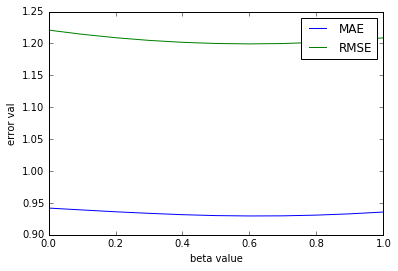

In [115]:
##
##  Plot beta value compare with 
##

plt.plot(beta_array, mae_array, label='MAE')
plt.plot(beta_array, rmse_array, label = 'RMSE')

plt.legend()
plt.ylabel('error val')
plt.xlabel('beta value')

plt.show()

Самое лучшее качество при beta = 0.6